In [8]:
import numpy as np
import math
import matplotlib.pyplot as plt

def init_weights_Glorot(n_in, n_out):  # Glorot uniform
    w = np.zeros((n_in, n_out))
    #sd = 6.0 / np.sqrt(n_in + n_out)
    sd = np.sqrt(6.0 / (n_in + n_out))
    for i in range(n_in):
        for j in range(n_out):
            x = np.float32(np.random.uniform(-sd, sd))
            w[i,j] = x
    return w

In [9]:
class autoencoder:
    # __init__
    # d is the dimension of input vector 
    # n1 is the dimension of the hidden layer
    # classes = 10
    # ------------------------------------
    # The constructor should initialize the weights and biases for the two layers, W1, W2, b1,
    # and b2. Initialize the biases to zero, and sample the initial weights using the Glorot

    def __init__(self, d, n1):
        
        self.d = d
        self.n1 = n1
        
        self.W1 = init_weights_Glorot(n1, d)
        self.b1 = np.zeros(n1)
        self.W2 = init_weights_Glorot(d, n1)
        self.b2 = np.zeros(d)
        
        self.dnh1 = np.zeros((n1,d))
        self.dhp1 = np.zeros((n1,d))
        self.dnh2 = np.zeros(n1)
        self.dhp2 = np.zeros(n1)
        self.dnh3 = np.zeros((d,n1))
        self.dhp3 = np.zeros((d,n1))
        self.dnh4 = np.zeros(d) 
        self.dhp4 = np.zeros(d)

        
    # Activation functions
    # ------------------------------------
    # They should accept matrix arguments and respectively return the pointwise evaluation of 
    # the ReLu and logistic sigmoid activation functions
    def h1(self, a):
        return np.maximum(0, a)
    def h2(self, a):
        return 1/(1 + np.exp(-a)) 
    
    # Activation derivatives functions (not used right now)
    # ------------------------------------
    # They should accept matrices and return the pointwise evaluation of the derivatives of 
    # the corresponding activation functions
    # derivative of relu 
    def dh1(self, a):
        s = self.h1(a)
        return np.greater(s, 0).astype(int)
    # derivative of sigmoid
    def dh2(self, a):
        s = self.h2(a)
        return s*(1-s)
    
    # Loss function 
    # ------------------------------------
    # computes the average binary cross-entropy reconstruction loss when the autoencoding of 
    # Xbatch is used to approximate Xbatch,
    def loss(self, Xb):
        ##print("-- loss --")
        Yb = self.forward(Xb)
        dm = np.size(Xb)
        loss = - (1/dm) * np.sum(np.multiply(Xb, np.log(Yb),out=np.zeros_like(Yb), where=Yb != 0 ) + np.multiply((1 - Xb),np.log(1 - Yb), out=np.zeros_like(Yb), where=1-Yb != 0))
        return loss
    # Loss derivative function
    # ------------------------------------
    # should assume that Ybatch was obtained by passing a minibatch through the autoencoder, 
    # and use the internal state of the autoencoder to compute the derivative of the loss above 
    # with respect to the output Ybatch
    def dloss(self, Yb):
        dm = np.size(self.Xbatch)
        Xb = self.Xbatch
        dloss = - (1 / dm) * ((np.divide(Xb, Yb, out=np.zeros_like(Yb), where=Yb != 0)) + (np.divide((Xb-1), (1 - Yb), out=np.zeros_like(Yb), where=(1 - Yb) != 0)))
        return dloss
    
    # forward function
    # ------------------------------------
    # Xbatch is a d x m matrix whose columns comprise a minibatch 
    # To facilitate their use in backpropagation, this function should store Xbatch and the
    # activations a1 and a2 and outputs o1 and o2 as instance attributes.
    def forward(self, Xbatch):
        ##print("-- forward --")
        self.Xbatch = Xbatch
        self.a1 = self.W1@Xbatch + np.reshape(self.b1,(self.n1,1))
        self.o1 = self.h1(self.a1)
        self.a2 = self.W2@self.o1+ np.reshape(self.b2,(self.d,1))
        self.o2= self.h2(self.a2)
        
        return self.o2
    
    # backward function 
    # ------------------------------------
    # This function should compute and store attributes dW1, dW2, db1, db2 containing 
    # the gradients of the training objective with respect to the parameters of the autoencoder, 
    # using the values stored from an earlier call to forward.
    def backward(self):
        ##print("-- backward --")

        del2     = self.dloss(self.o2)*self.dh2(self.a2)
        self.dW2 = del2@self.o1.T
        self.db2 = np.sum(del2,axis = 1)
        del1     = (self.W2.T@del2)*self.dh1(self.a1)
        self.dW1 = del1@self.Xbatch.T
        self.db1 = np.sum(del1,axis = 1)
        
        
    # Adam optimizer function(ref hw pdf)
    # ------------------------------------
    
    def adam_step(self, itr, alpha=0.001, rho1=0.9, rho2=0.999, delta=1e-8):
        self.dnh1 = rho1*self.dnh1 + (1-rho1)*self.dW1
        self.dhp1 = rho2*self.dhp1 + (1-rho2)*self.dW1*self.dW1
        nudh = (1-rho1**itr)**(-1)*self.dnh1
        nuh = (1-rho2**itr)**(-1)*self.dhp1
        self.W1 = self.W1 -alpha*(nudh/(nuh**0.5+delta)) #update W1
        
        self.dnh2 = rho1*self.dnh2 + (1-rho1)*self.db1
        self.dhp2 = rho2*self.dhp2 + (1-rho2)*self.db1*self.db1
        nudh = (1-rho1**itr)**(-1)*self.dnh2
        nuh = (1-rho2**itr)**(-1)*self.dhp2
        self.b1 = self.b1 -alpha*(nudh/(nuh**0.5+delta)) #update b1
        
        self.dnh3 = rho1*self.dnh3 + (1-rho1)*self.dW2
        self.dhp3 = rho2*self.dhp3 + (1-rho2)*self.dW2*self.dW2
        nudh = (1-rho1**itr)**(-1)*self.dnh3
        nuh = (1-rho2**itr)**(-1)*self.dhp3
        self.W2 = self.W2 -alpha*(nudh/(nuh**0.5+delta)) #update W2
        
        self.dnh4 = rho1*self.dnh4 + (1-rho1)*self.db2
        self.dhp4 = rho2*self.dhp4 + (1-rho2)*self.db2*self.db2
        nudh = (1-rho1**itr)**(-1)*self.dnh4
        nuh = (1-rho2**itr)**(-1)*self.dhp4
        self.b2= self.b2 -alpha*(nudh/(nuh**0.5+delta)) #update b2

In [32]:
# ------------------------------------
# Load fashion_MNIST from keras
# ------------------------------------
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import tensorflow as tf

(Xtrain, Ytrain), (Xtest, Ytest) = fashion_mnist.load_data()

Xtrain = Xtrain / 255.0
Xtest = Xtest / 255.0
Xtrain = np.transpose(tf.reshape(Xtrain,[60000,784]))

d = 784
n1 = 100
ntrain = np.arange(60000)
numepochs = 20
numsplits = 400
ae = autoencoder(d, n1)
itr = 1

for e in range(numepochs):
    print('Training loss [%d/%d]: %.2f' % (e+1, numepochs, ae.loss(Xtrain)))
    minibatches = np.split(np.random.permutation(ntrain), numsplits)
    for indices in minibatches:
        Xbatch = Xtrain[:, indices]
        ae.forward(Xbatch)
        ae.backward()
        ae.adam_step(itr)
        itr += 1 #update itr for adam

Training loss [1/20]: 0.70
Training loss [2/20]: 0.30
Training loss [3/20]: 0.28
Training loss [4/20]: 0.28
Training loss [5/20]: 0.27
Training loss [6/20]: 0.27
Training loss [7/20]: 0.27
Training loss [8/20]: 0.27
Training loss [9/20]: 0.27
Training loss [10/20]: 0.27
Training loss [11/20]: 0.27
Training loss [12/20]: 0.27
Training loss [13/20]: 0.27
Training loss [14/20]: 0.27
Training loss [15/20]: 0.27
Training loss [16/20]: 0.26
Training loss [17/20]: 0.26
Training loss [18/20]: 0.26
Training loss [19/20]: 0.26
Training loss [20/20]: 0.26


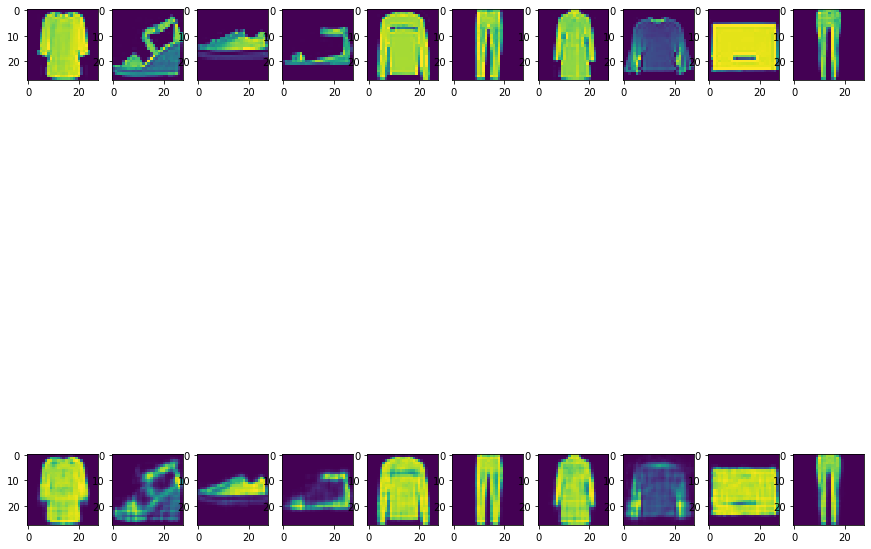

In [33]:
Xtest = np.transpose(tf.reshape(Xtest,[10000,784]))

# plot the figure with the original data
f, axarr = plt.subplots(2,10,figsize=(15,15))
count = []
i = 0
rand = np.arange(10000) #select random class
np.random.shuffle(rand)
while i < np.size(Ytrain) and np.size(count) <=9:
    
    if Ytrain[rand[i]] not in count:     
        count.append(Ytrain[rand[i]])
        j = np.size(count)
        axarr[(0,(j-1))].imshow(np.reshape(Xtest[:,rand[i]]*255,(28,28))) #rescale and plot
        ae.forward(np.reshape(Xtest[:,rand[i]],(784,1)))
        Image = ae.o2
        axarr[(1,(j-1))].imshow(np.reshape(Image*255,(28,28)))
        
    i = i + 1

In [34]:
print("FINAL LOSS:",ae.loss(Xtest))

FINAL LOSS: 0.26661104871109065
